In [1]:
import sys
sys.path.append('core')

import argparse
import os
import cv2
import glob
import numpy as np
import torch
from PIL import Image

from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

In [2]:
DEVICE = 'cuda'

def readFlow(fn):
    """ Read .flo file in Middlebury format"""
    with open(fn, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if 202021.25 != magic:
            print('Magic number incorrect. Invalid .flo file')
            return None
        else:
            w = np.fromfile(f, np.int32, count=1)
            h = np.fromfile(f, np.int32, count=1)
            # print 'Reading %d x %d flo file\n' % (w, h)
            data = np.fromfile(f, np.float32, count=2*int(w)*int(h))
            # Reshape data into 3D array (columns, rows, bands)
            # The reshape here is for visualization, the original code is (w,h,2)
            return np.resize(data, (int(h), int(w), 2))

def load_image(imfile):
    img = np.array(Image.open(imfile).convert('RGB')).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()

    return img[None].to(DEVICE)

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('--small', action='store_true', default=False, help='use small model')
parser.add_argument('--mixed_precision', action='store_true', default=True, help='use mixed precision')
parser.add_argument('--alternate_corr', action='store_true', default=False, help='use efficent correlation implementation')
args = parser.parse_args("")

In [177]:
model1 = torch.nn.DataParallel(RAFT(args))
model1.load_state_dict(torch.load('FB_InletVel_Models/raft-boiling-sintel.pth'))
model2 = torch.nn.DataParallel(RAFT(args))
model2.load_state_dict(torch.load('models/raft-sintel.pth'))

model1 = model1.module
model1.to(DEVICE)
model1.eval()
model2 = model2.module
model2.to(DEVICE)
model2.eval()

with torch.no_grad():
    images = glob.glob(os.path.join('datasets/FB_InletVelocity/valid/inletVelScale-1.5/img/', '*.png'))
    gt_flows = glob.glob(os.path.join('datasets/FB_InletVelocity/valid/inletVelScale-1.5/flow/', '*.flo'))

    images = sorted(images)
    gt_flows = sorted(gt_flows)
    imfile1 = images[15]
    imfile2 = images[16]
    gt_flow = gt_flows[15]

    image1 = load_image(imfile1)
    image2 = load_image(imfile2)
    flow_gt = readFlow(gt_flow)
    flow_gt = torch.from_numpy(flow_gt).permute(2, 0, 1).float()
    flow_gt = flow_gt.unsqueeze(0)
    flow_gt = flow_gt.cuda()
    _, flow_pr_1= model1(image1, image2, iters=24, test_mode=True)
    _, flow_pr_2= model2(image1, image2, iters=24, test_mode=True)


/tmp/sheikhh1/23771062/ipykernel_3985597/4045929535.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = np.fromfile(f, np.float32, count=2*int(w)*int(h))
/tmp/sheikhh1/23771062/ipykernel_3985597/4045929535.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.resize(data, (int(h), int(w), 2))


In [178]:
epe_1 = torch.sum((flow_pr_1 - flow_gt) ** 2, dim=1).sqrt()
epe_2 = torch.sum((flow_pr_2 - flow_gt) ** 2, dim=1).sqrt()

In [179]:
epe_mag_1 = epe_1.cpu().detach().numpy()[0]
epe_mag_1 = epe_mag_1/epe_mag_1.max().item()
epe_mag_2 = epe_2.cpu().detach().numpy()[0]
epe_mag_2 = epe_mag_2/epe_mag_2.max().item()


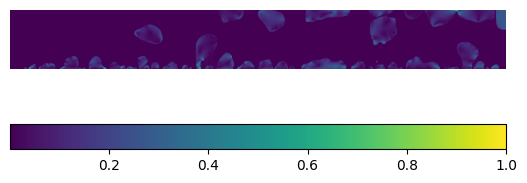

In [180]:
import matplotlib.pyplot as plt
plt.imshow(epe_mag_1)
plt.colorbar(location="bottom")
plt.axis('off')
plt.savefig("finetuned_error.png", bbox_inches='tight')

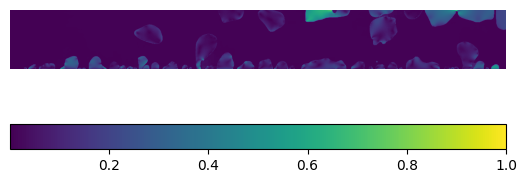

In [181]:
import matplotlib.pyplot as plt
plt.imshow(epe_mag_2)
plt.colorbar(location="bottom")
plt.axis('off')
plt.savefig("pretrained_error.png", bbox_inches='tight')

In [182]:
from torchvision.utils import flow_to_image
from torchvision.transforms import functional as F
flow_gt_img = flow_to_image(flow_gt).cpu().detach()
flow_pr_img_1 = flow_to_image(flow_pr_1).cpu().detach()
flow_pr_img_2 = flow_to_image(flow_pr_2).cpu().detach()


In [183]:
flow_gt_pil = F.to_pil_image(flow_gt_img[0])
flow_pr_pil_1 = F.to_pil_image(flow_pr_img_1[0])
flow_pr_pil_2 = F.to_pil_image(flow_pr_img_2[0])

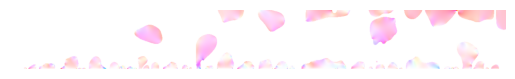

In [184]:
img = plt.imshow(flow_gt_pil)
plt.axis('off')
plt.savefig("flow_gt.png", bbox_inches='tight')

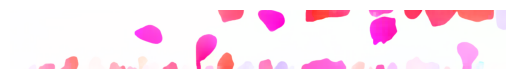

In [185]:
plt.imshow(flow_pr_pil_1)
plt.axis('off')
plt.savefig("finetuned.png", bbox_inches='tight')

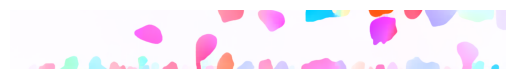

In [186]:
plt.imshow(flow_pr_pil_2)
plt.axis('off')
plt.savefig("pretrained.png", bbox_inches='tight')